# Step 3: Pre-processing and Training Data Development

### Load Data and Import Packages

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve


In [4]:
# Import clean data
datapath = '/Users/kbrewitt/Github/Predicting Longevity Using Urban Greenspace/clean_data/London_data_cleaned.csv'
df = pd.read_csv(datapath, index_col=0)

In [7]:
# Check imported data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   New ward code                3275 non-null   object 
 1   Ward                         3275 non-null   object 
 2   Borough                      3275 non-null   object 
 3   Year                         3275 non-null   int64  
 4   Life_Expectancy              3275 non-null   float64
 5   Childhood_Obesity            3275 non-null   float64
 6   Incapacity_Benefit           3275 non-null   float64
 7   Unemployment                 3275 non-null   float64
 8   Crime                        3275 non-null   float64
 9   Deliberate_Fires             3275 non-null   float64
 10  GCSE_points                  3275 non-null   float64
 11  Unauthorised_School_Absence  3275 non-null   float64
 12  Dependent_children           3275 non-null   float64
 13  Public_Transport_A

,New ward code,Ward,Borough,Year,Life_Expectancy,Childhood_Obesity,Incapacity_Benefit,Unemployment,Crime,Deliberate_Fires,GCSE_points,Unauthorised_School_Absence,Dependent_children,Public_Transport_Access,Greespace_Access,Borough Green Space Surface
0,E09000001,City of London,City of London,2009,84.329356,22.220000,3.333333,2.999195,18.389167,0.684932,346.80,0.24,17.14,7.723401,-6.478752,4.8
1,E05000026,Abbey,Barking and Dagenham,2009,82.076112,21.700880,4.586610,8.325803,180.721564,1.908646,311.29,1.22,37.71,5.987356,-0.889538,33.6
2,E05000027,Alibon,Barking and Dagenham,2009,77.828392,25.974026,7.033561,9.857754,125.168618,1.099268,302.16,1.53,40.00,3.275530,-1.790968,33.6
3,E05000028,Becontree,Barking and Dagenham,2009,78.430683,22.448980,6.734643,9.405173,149.022537,0.967892,320.30,1.55,37.59,2.848544,-5.469666,33.6
4,E05000029,Chadwell Heath,Barking and Dagenham,2009,79.887841,23.795181,6.675432,8.567379,135.434080,1.850122,324.70,1.22,39.66,2.272302,1.977718,33.6


### 1a. Convert Borough Greenspace into a categorical variable

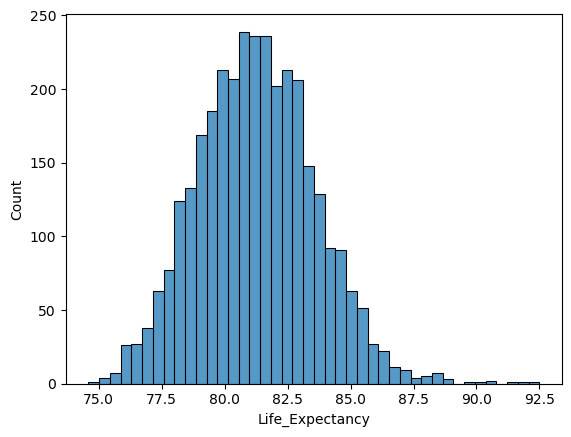

In [13]:
sns.histplot(df['Borough Green Space Surface'])
plt.show();

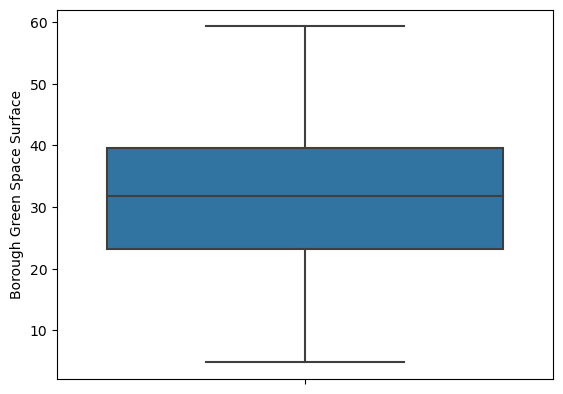

In [34]:
# Examine quantiles
sns.boxplot(y='Borough Green Space Surface', data=df);

In [35]:
#Create new categorical column for greenspace (Low, Medium, High)
df['Total_Greenspace'] = pd.cut(df['Borough Green Space Surface'], bins=3, labels=['Low', 'Medium', 'High'])
df.head()

,New ward code,Ward,Borough,Year,Life_Expectancy,Childhood_Obesity,Incapacity_Benefit,Unemployment,Crime,Deliberate_Fires,GCSE_points,Unauthorised_School_Absence,Dependent_children,Public_Transport_Access,Greespace_Access,Borough Green Space Surface,Total_Greenspace
0,E09000001,City of London,City of London,2009,84.329356,22.220000,3.333333,2.999195,18.389167,0.684932,346.80,0.24,17.14,7.723401,-6.478752,4.8,Low
1,E05000026,Abbey,Barking and Dagenham,2009,82.076112,21.700880,4.586610,8.325803,180.721564,1.908646,311.29,1.22,37.71,5.987356,-0.889538,33.6,Medium
2,E05000027,Alibon,Barking and Dagenham,2009,77.828392,25.974026,7.033561,9.857754,125.168618,1.099268,302.16,1.53,40.00,3.275530,-1.790968,33.6,Medium
3,E05000028,Becontree,Barking and Dagenham,2009,78.430683,22.448980,6.734643,9.405173,149.022537,0.967892,320.30,1.55,37.59,2.848544,-5.469666,33.6,Medium
4,E05000029,Chadwell Heath,Barking and Dagenham,2009,79.887841,23.795181,6.675432,8.567379,135.434080,1.850122,324.70,1.22,39.66,2.272302,1.977718,33.6,Medium


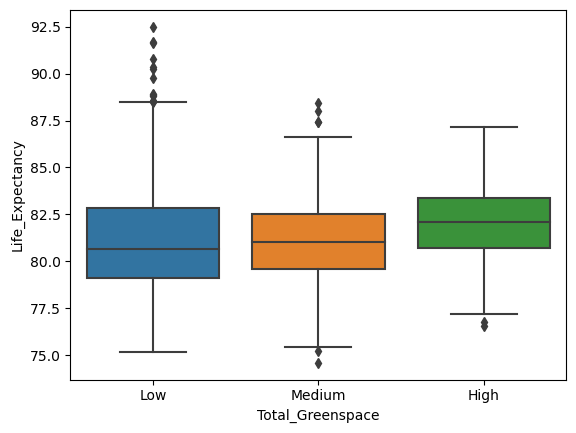

In [41]:
# Examine new categorical column for greenspace
sns.boxplot(x='Total_Greenspace', y='Life_Expectancy', data=df);

## 1b. Remove columns unnecessary for model
Since I a not looking at the change in time as a variable, I will remove the Year variable. <br>
The Ward variables are also redundant with Borough -- I will keep Borough only (to be used as a categorical variable) since that is the level of detail with which the data was collected. 

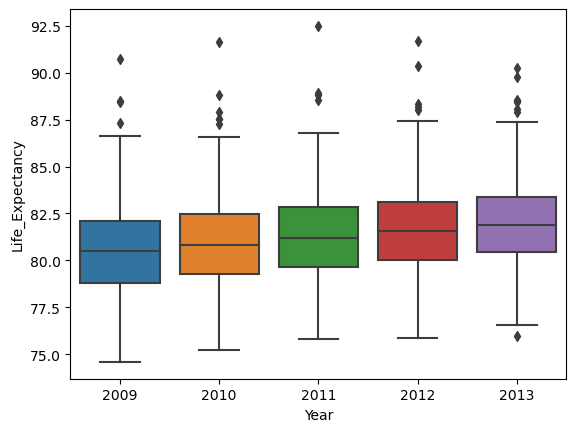

In [42]:
# Examine Life Expectancy Across Years
sns.boxplot(x='Year', y='Life_Expectancy', data=df);

In [45]:
# Drop unwanted columns
# Dropping Ward columns, Year, and old greenspace column (replaced by categorical variable)
df_longevity = df.drop(columns=['New ward code', 'Ward', 'Year', 'Borough Green Space Surface'])

In [46]:
df_longevity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3275 entries, 0 to 3274
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Borough                      3275 non-null   object  
 1   Life_Expectancy              3275 non-null   float64 
 2   Childhood_Obesity            3275 non-null   float64 
 3   Incapacity_Benefit           3275 non-null   float64 
 4   Unemployment                 3275 non-null   float64 
 5   Crime                        3275 non-null   float64 
 6   Deliberate_Fires             3275 non-null   float64 
 7   GCSE_points                  3275 non-null   float64 
 8   Unauthorised_School_Absence  3275 non-null   float64 
 9   Dependent_children           3275 non-null   float64 
 10  Public_Transport_Access      3275 non-null   float64 
 11  Greespace_Access             3275 non-null   float64 
 12  Total_Greenspace             3275 non-null   category
dtypes: 

## 1. Train-test split data

In [152]:
df_longevity.shape

(3275, 13)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(df_longevity.drop(columns='Life_Expectancy'), 
                                                    df_longevity.Life_Expectancy, test_size=0.2, 
                                                    random_state=43)

In [154]:
X_train.shape, X_test.shape

((2620, 12), (655, 12))

In [155]:
y_train.shape, y_test.shape

((2620,), (655,))

In [156]:
#Check the `dtypes` attribute of `X_train` 
X_train.dtypes

Borough                          object
Childhood_Obesity               float64
Incapacity_Benefit              float64
Unemployment                    float64
Crime                           float64
Deliberate_Fires                float64
GCSE_points                     float64
Unauthorised_School_Absence     float64
Dependent_children              float64
Public_Transport_Access         float64
Greespace_Access                float64
Total_Greenspace               category
dtype: object

## 2. Scale numberical variables
Use StandardScalar to scale numeric variables to a standardized scale. The StandardScaler scales each feature to zero mean and unit variance.

In [172]:
# Drop categorical features
cat_cols = ['Borough', 'Total_Greenspace']
X_train_num = X_train.drop(columns=cat_cols)
X_test_num = X_test.drop(columns=cat_cols)

In [173]:
# Fit scaler to training data and transform training and test data
scaler = StandardScaler()
scaler.fit(X_train_num)
X_tr_scaled = scaler.transform(X_train_num)
X_te_scaled = scaler.transform(X_test_num)


In [174]:
X_tr_scaled.shape

(2620, 10)

In [175]:
X_te_scaled.shape

(655, 10)

In [176]:
# Create new scaled dataframes for X_train and X_test data
col_names = X_train.columns.drop(['Borough', 'Total_Greenspace'])

# Training data
X_tr_num = pd.DataFrame(X_tr_scaled, columns=col_names)
X_tr_num['Borough'] = X_train['Borough']
X_tr_num['Total_Greenspace'] = X_train['Total_Greenspace']

# Test data
X_te_num = pd.DataFrame(X_te_scaled, columns=col_names)
X_te_num['Borough'] = X_test['Borough']
X_te_num['Total_Greenspace'] = X_test['Total_Greenspace']


In [177]:
## TRYING SOMETHING OUT -- Trying to use pd.concat method to join dataframes but it's not working!
# Training data 
col_names = X_train.columns.drop(['Borough', 'Total_Greenspace'])

X_tr_num_trial = pd.DataFrame(X_tr_scaled, columns=col_names)
X_tr_num_trial1 = pd.concat([X_tr_num, X_train[['Borough', 'Total_Greenspace']]], axis=1)
#X_tr_num_trial1

In [178]:
X_tr_num.shape

(2620, 12)

In [179]:
X_te_num.shape

(655, 12)

## 3. Create dummy variables for categorical data
Categorical columns are Borough and Total_Greenspace

In [180]:
# Convert the Borough and Total Greenspace columns to a one hot encoded Data Frame on both training and test data
X_train_oh = pd.get_dummies(X_tr_num, columns=['Borough', 'Total_Greenspace'], prefix=['B','TG'])
X_test_oh = pd.get_dummies(X_te_num, columns=['Borough', 'Total_Greenspace'], prefix=['B','TG'])


In [181]:
X_train_oh.shape

(2620, 46)

In [183]:
# NOTE -- this has two fewer columns that the X_train
# Is this because it's a smaller dataset? 
# Indicating we should create dummy variables before the train/test split?
X_test_oh.shape

(655, 44)

In [150]:
X_train_oh

,Childhood_Obesity,Incapacity_Benefit,Unemployment,Crime,Deliberate_Fires,GCSE_points,Unauthorised_School_Absence,Dependent_children,Public_Transport_Access,Greespace_Access,...,B_Richmond upon Thames,B_Southwark,B_Sutton,B_Tower Hamlets,B_Waltham Forest,B_Wandsworth,B_Westminster,TG_Low,TG_Medium,TG_High
0,0.526738,1.084823,0.979146,0.606967,1.165893,-0.684345,0.841939,0.847403,-0.493617,-0.214932,...,0,0,0,0,0,0,0,1,0,0
1,-0.464170,-0.608248,-1.105710,-1.322560,-0.467811,0.037330,-1.206214,-1.228399,-1.189103,-0.704068,...,0,0,0,0,0,0,0,0,1,0
2,-0.588929,-0.715846,-0.438911,-0.322606,-0.655606,0.722037,-0.091025,-0.980037,-0.203790,-1.287273,...,0,0,0,0,0,0,0,0,1,0
3,0.677987,2.221829,0.676289,1.214693,-0.095602,-2.233604,1.763608,1.955701,1.472619,-0.955020,...,0,0,0,0,0,0,0,0,1,0
4,-1.556106,-1.278908,-0.838376,-1.146580,0.217088,1.125096,-0.245492,-1.089755,-1.190706,2.640664,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2615,-1.827854,-1.350301,-1.259221,-1.172001,-0.590286,2.051663,-1.813596,-1.697643,-0.818300,-0.025566,...,1,0,0,0,0,0,0,0,0,1
2616,0.954665,-0.286079,0.601459,0.090562,-0.741846,0.405441,0.274087,-0.169391,-0.540088,0.137349,...,0,1,0,0,0,0,0,0,1,0
2617,1.091483,0.773789,0.041706,3.578440,-0.834321,0.457820,0.180082,0.292161,1.402247,0.946535,...,0,0,1,0,0,0,0,0,1,0
2618,-0.738009,-1.085944,-0.978977,-1.063732,-0.025481,1.243431,-0.527610,-1.253124,-0.557988,1.354058,...,0,0,0,1,0,0,0,1,0,0


In [184]:
X_train_oh.dtypes

Childhood_Obesity              float64
Incapacity_Benefit             float64
Unemployment                   float64
Crime                          float64
Deliberate_Fires               float64
GCSE_points                    float64
Unauthorised_School_Absence    float64
Dependent_children             float64
Public_Transport_Access        float64
Greespace_Access               float64
B_Barking and Dagenham           uint8
B_Barnet                         uint8
B_Bexley                         uint8
B_Brent                          uint8
B_Bromley                        uint8
B_Camden                         uint8
B_City of London                 uint8
B_Croydon                        uint8
B_Ealing                         uint8
B_Enfield                        uint8
B_Greenwich                      uint8
B_Hackney                        uint8
B_Hammersmith and Fulham         uint8
B_Haringey                       uint8
B_Harrow                         uint8
B_Havering               

I now have an all numeric dataset that is ready for modeling. It contains scaled numerical variables, as well as two categorical variables (Borough and Total_Greenspace) that have been dummy-encoded for modeling. The final matrix is 2620 x 46. <br>
<br>
One issue that needs to be resolved is that the test set (X_test) is only 2620 x 44 (two columns fewer). I suspect the problem was in creating the dummy variables for a smaller dataset, and ending up with some all 0 columns. 